In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency as chi2_contingency

In [2]:
bio = pd.read_csv('../../dataset/Agriculture_biologique_final.csv', sep ="\t")
env = pd.read_csv('../../dataset/Impact environnemental_final.csv',sep ="\t", low_memory = False)
qual = pd.read_csv('../../dataset/Qualite nutritionnelle_final.csv',sep ="\t",low_memory = False)

# 0  Nettoyage

Nettoyage de env : 

In [3]:
env.drop_duplicates(inplace=True)

In [4]:
env_brand_missing = env.loc[env.brands_tags.isnull()].index
env_Wmarques= env.drop(index=env_brand_missing)

In [14]:
ind_sans_marques_env = env_Wmarques[env_Wmarques.brands_tags == 'sans-marque'].index
env_Wmarques= env_Wmarques.drop(index=ind_sans_marques_env)

Index([ 12910,  13000,  13249,  14385,  14606,  15451,  15468,  15774,  15891,
        17046,
       ...
       507761, 508882, 511633, 533879, 548460, 557001, 559281, 562101, 577533,
       582983],
      dtype='int64', length=667)

Nettoyage de qual : 

In [5]:
qual.drop_duplicates(inplace=True)

In [6]:
qual["energy-kcal_100g"] = qual["energy-kcal_100g"][qual["energy-kcal_100g"] > 0]

In [8]:
ind_qual_brand_missing = qual.loc[qual.brands_tags.isnull()].index
qual_Wmarques= qual.drop(index=ind_qual_brand_missing)

In [9]:
ind_sans_marques_qual = qual_Wmarques[qual_Wmarques.brands_tags == 'sans-marque'].index
qual_Wmarques = qual_Wmarques.drop(index=ind_sans_marques_qual)

Nettoyage de bio : 

In [18]:
# on enlève la colonne bio
bio.drop(columns=['serving_size'], inplace=True)
bio.drop_duplicates(inplace=True)

In [19]:
ind_bio_brand_missing = bio.loc[bio.brands_tags.isnull()].index
bio_Wmarques= bio.drop(index=ind_bio_brand_missing)

In [21]:
ind_sans_marques_bio = bio_Wmarques[bio_Wmarques.brands_tags == 'sans-marque'].index
bio_Wmarques = bio_Wmarques.drop(index=ind_sans_marques_bio)

## 0.1 Regroupement des datasets

Colonnes communes env & qual

Merge des df env et qual

In [28]:
envqual = env.merge(qual, on = ['code', 'product_name', 'quantity', 'brands_tags', 'countries_tags','image_url'], how='outer', indicator='merged_qual')

Colonnes communes envqual et bio

Merge des df env et qual

In [29]:
envqualbio = envqual.merge(bio, on=['product_name', 'brands_tags'], how='outer', indicator='merged_bio')

On supprime les doublons

In [30]:
envqualbio.drop(columns=['serving_size_x','serving_size_y'], inplace=True)

In [31]:
envqualbio = envqualbio.drop_duplicates()

In [32]:
envqualbio.reset_index(inplace=True)

In [33]:
envqualbio.drop(columns='index',inplace=True)

# 1. Quelles sont les marques qui jouent le jeu et affichent le nutriscore ? Lesquelles ne le font pas?

# 2. Quelles sont les marques qui ont le plus recours aux additifs nocifs ?

In [10]:
ind_brand_missing = envqualbio.loc[envqualbio.brands_tags.isnull()].index
df_Wmarques= envqualbio.drop(index=ind_brand_missing)

NameError: name 'envqualbio' is not defined

## 2.1 Définition d'un seuil de nombre de produit par marque

In [11]:
sum_prod = qual_Wmarques[qual_Wmarques['product_name'].notnull()].groupby('brands_tags').size()
qual_Wmarques['count_prod'] = qual_Wmarques['brands_tags'].map(sum_prod)
seuil = 500
qual_gdemarq = qual_Wmarques[qual_Wmarques.count_prod >= seuil]
qual_ptemarq = qual_Wmarques[qual_Wmarques.count_prod < seuil]

Affichage des 10 marques ayant le plus recours aux additifs nocifs (pour les marques ayant plus de 500 produits) :

In [12]:
ten_worst_nocive_brands_gde = qual_gdemarq.groupby('brands_tags').nb_nocif.sum().sort_values(ascending=False)[:10]

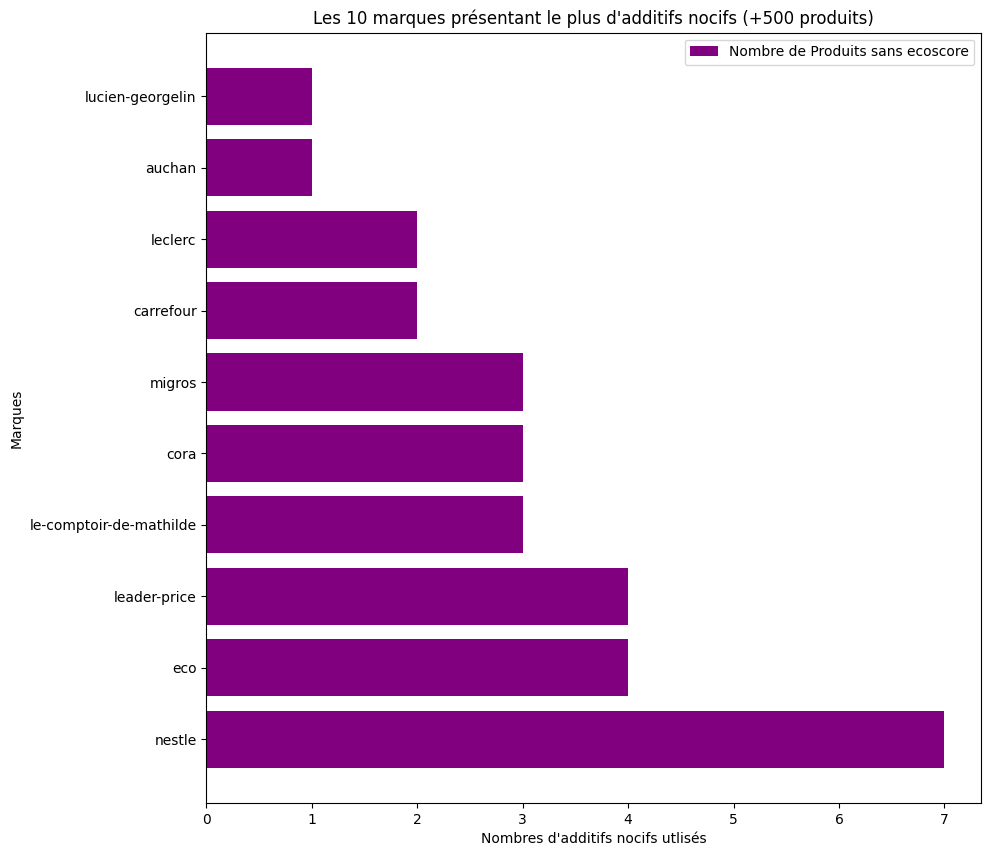

In [29]:
plt.figure(figsize=(10,10))
plt.barh(y = ten_worst_nocive_brands_gde.index  , color='purple', width=ten_worst_nocive_brands_gde)
plt.ylabel('Marques')
plt.xlabel("Nombres d'additifs nocifs utlisés")
plt.title("Les 10 marques présentant le plus d'additifs nocifs (+500 produits)")
plt.legend(labels=['Nombre de Produits sans ecoscore','Nombre de produits de la marque'])
plt.show()

In [102]:
ten_worst_nocive_brands = qual_Wmarques.groupby('brands_tags').nb_nocif.sum().sort_values(ascending=False)[:10]

In [27]:
plt.barh(y = ten_worst_nocive_brands.index  , color='purple', width=ten_worst_nocive_brands)
plt.ylabel('Marques')
plt.xlabel("Nombres d'additifs nocifs utilisés")
plt.title("Les 10 marques présentant le plus d'additifs nocifs")
plt.legend(labels=['Nombre de Produits sans ecoscore','Nombre de produits de la marque'])
plt.show()

NameError: name 'ten_worst_nocive_brands' is not defined

Donc en regroupant les informations on peut déconseiller : <br>
- Sodastream
- Nestle
- A-rom
- Dove
- Nestle
- Schweppes
- Freeway
- Steff Fruiss
- Eco
- Leader Price
- Cora
- Leclerc
- Carrefour
- Auchan
- Lucien Georgelin

# 4. Quelles sont les marques qui jouent le jeu et affichent l'ecoscore ? Lesquelles ne le font pas?

Afin de déterminer quelles marques jouent le jeu de celles qu'ils ne le font pas, on différencie ici les marques en 2 groupes : <br>
- Les "grandes" marques ayant un nombre de produit "important"
- Les "petites" marques qui auront peu de proposés

## 4.1 Définition d'un seuil de nombre de produit par marque

In [37]:
sum_ecoscore = env_Wmarques[env_Wmarques['ecoscore_grade'].notnull()].groupby('brands_tags').size()
env_Wmarques['count_prod'] = env_Wmarques['brands_tags'].map(sum_ecoscore)
seuil = 500
df_gdemarq = env_Wmarques[env_Wmarques.count_prod >= seuil]
df_ptemarq = env_Wmarques[env_Wmarques.count_prod < seuil]

## 4.2 Ecoscore des "grandes" marques

### 4.2.1 Quels sont les "bons" élèves ? 

##### Marques présentant la meilleure présence d'ecoscore 

In [40]:
count_nut_W = df_gdemarq.brands_tags.loc[df_gdemarq.ecoscore_grade.isin(['d','c', 'b', 'not-applicable', 'a', 'e'])].value_counts()[:10]

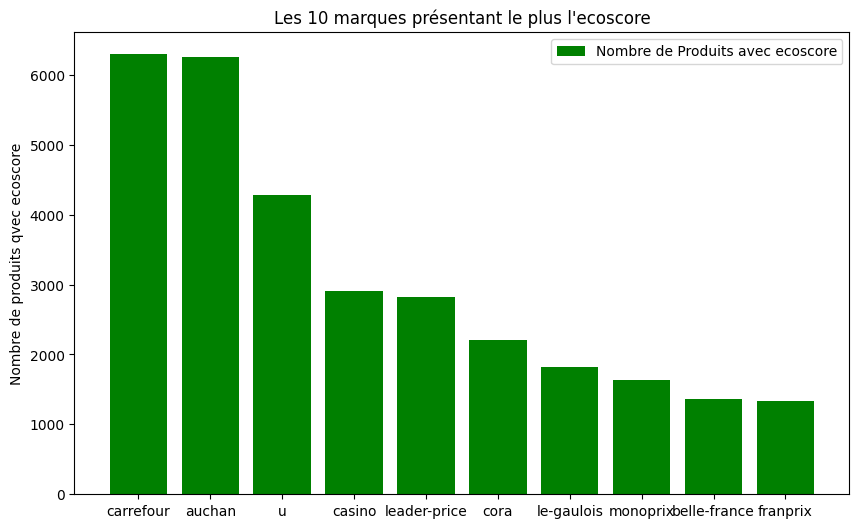

In [41]:
plt.figure(figsize=(10,6))
plt.bar(x = count_nut_W.index , height = count_nut_W, color='g')
plt.ylabel('Nombre de produits qvec ecoscore')
plt.title('Les 10 marques présentant le plus l\'ecoscore')
plt.legend(labels=['Nombre de Produits avec ecoscore','Nombre de produits de la marque'])
plt.show()

##### Marques qui utilisent le plus l'ecoscore

In [42]:
ratio_eco_good = (count_nut_W[:10] / df_gdemarq.brands_tags[df_gdemarq.brands_tags.isin(count_nut_W[:10].index)].value_counts()).sort_values(ascending=False)

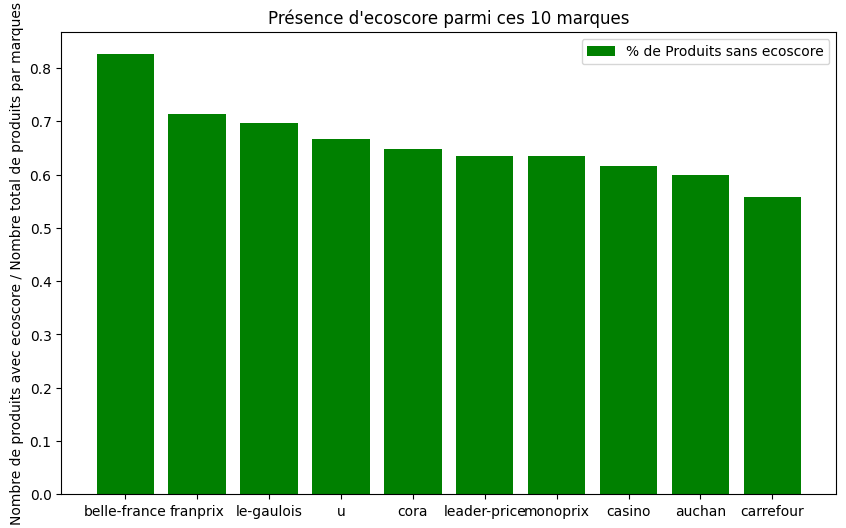

In [73]:
plt.figure(figsize=(10,6))
plt.bar(x = ratio_eco_good.index , height = ratio_eco_good, color='g')
plt.ylabel('Nombre de produits avec ecoscore / Nombre total de produits par marques')
plt.title("Présence d'ecoscore parmi ces 10 marques")
plt.legend(labels=['% de Produits sans ecoscore'])
plt.show()

### 4.2.2Quels sont les "mauvais" élèves ? 

##### Marques présentant le plus d'absence d'ecoscore 

In [44]:
count_nut_miss = df_gdemarq.brands_tags.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull()) ].value_counts().sort_values(ascending=False)[:10]
count_nut = df_gdemarq.brands_tags.loc[df_gdemarq.brands_tags.isin(count_nut_miss.index)].value_counts()

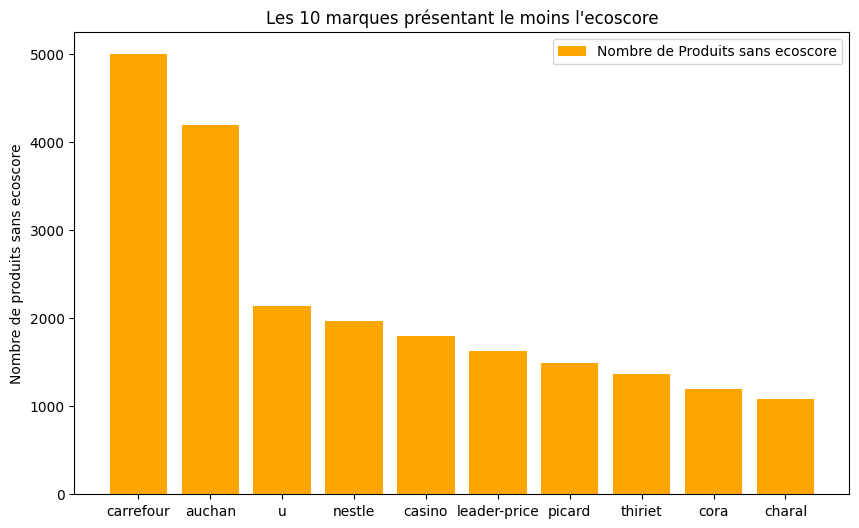

In [45]:
plt.figure(figsize=(10,6))
plt.bar(x = count_nut_miss.index , height = count_nut_miss, color='orange')
plt.ylabel('Nombre de produits sans ecoscore')
plt.title('Les 10 marques présentant le moins l\'ecoscore')
plt.legend(labels=['Nombre de Produits sans ecoscore','Nombre de produits de la marque'])
plt.show()

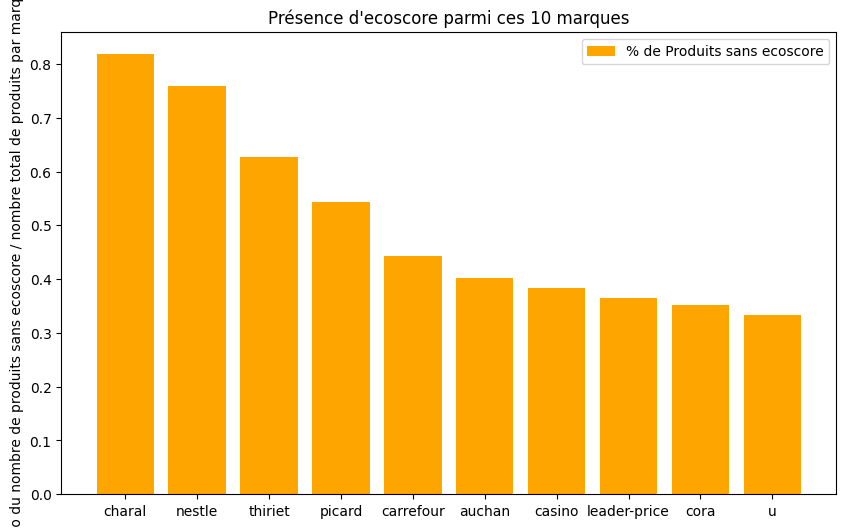

In [46]:
ratio_eco_brand = (count_nut_miss / count_nut).sort_values(ascending=False)
plt.figure(figsize=(10,6))
plt.bar(x = ratio_eco_brand.index , height = ratio_eco_brand, color='orange')
plt.ylabel('Ratio du nombre de produits sans ecoscore / nombre total de produits par marques')
plt.title("Présence d'ecoscore parmi ces 10 marques")
plt.legend(labels=['% de Produits sans ecoscore'])
plt.show()

##### Marques qui utilisent le moins l'ecoscore

In [47]:
count_nut_miss_p = df_gdemarq.brands_tags.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull()) ].value_counts()
count_nut_p = df_gdemarq.brands_tags.value_counts()
ratio_ecoscore_presence  = (count_nut_miss_p /count_nut_p).sort_values(ascending=False)

Pourcentage d'absence d'ecoscore 

In [48]:
p_gde_ecoMiss = df_gdemarq.loc[df_gdemarq.ecoscore_grade.isin(['d','c', 'b', 'not-applicable', 'a', 'e'])].ecoscore_grade.count() /df_gdemarq.ecoscore_grade.count() * 100

In [49]:
nb_miss_gde = df_gdemarq.loc[(df_gdemarq.ecoscore_grade.isin(['unknown'])) | (df_gdemarq.ecoscore_grade.isnull())].groupby('brands_tags').ecoscore_grade.count() / df_gdemarq.groupby('brands_tags').ecoscore_grade.count()
nb_miss_gde.std() * 100

19.07604914484398

## 4.3 Présence Ecoscore des "petites" marques 

Au vu du nombre de produits de ces marques, on ne va pas essayer de tirer des conclusions pour chacune d'elles mais on va essayer de voir s'il on retrouve une tendance parmi celles-ci.

In [52]:
p_nut_miss_pte = df_ptemarq.loc[(df_ptemarq.ecoscore_grade.isin(['unknown'])) | (df_ptemarq.ecoscore_grade.isnull()) ].brands_tags.count() / df_ptemarq.ecoscore_grade.count() * 100
p_nut_miss_pte

52.622024383117086

In [53]:
nb_miss = df_ptemarq.loc[(df_ptemarq.ecoscore_grade.isin(['unknown'])) | (df_ptemarq.ecoscore_grade.isnull())].groupby('brands_tags').ecoscore_grade.count() / df_ptemarq.groupby('brands_tags').ecoscore_grade.count()
nb_miss.std() * 100

26.05402201284168

## 4.4 Bilan 

Comparaison % présence  nutriscore pte marques / gde marques <br>
Grandes marques : bonnes et mauvaises élèves

Grandes Marques affichant leur nutriscore : <br>
- 1. belle-france 
- 2. franprix 
- 3. le-gaulois
- 4. u 
- 5. cora 
- 6. leader-price
- 7. monoprix
- 8. casino
- 9. auchan 
- 10. carrefour

Grandes Marques jouant moins le moins le jeu : <br>
- 1. charal
- 2. nestle 
- 3. thiriet
- 4. picard
- 5. carrefour
- 6. auchan
- 7. casino
- 8. leader-price
- 9. cora
- 10. u

Dans l'affichage de l'ecoscore, observe-t-on une différence entre les grandes marques, des petites ? 

[Text(0, 0, '52.622'), Text(0, 0, '53.2924')]

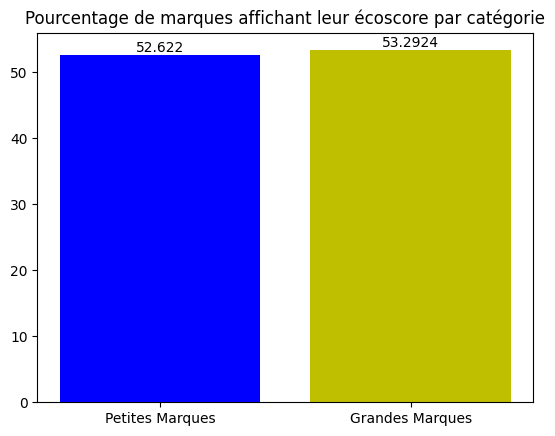

In [54]:
fig, ax = plt.subplots()
bars = ax.bar(['Petites Marques','Grandes Marques'], [p_nut_miss_pte,p_gde_ecoMiss], color = ['b','y'])
plt.title('Pourcentage de marques affichant leur écoscore par catégorie')
ax.bar_label(bars)

# 5. Quelles sont les marques qui semblent le plus respectueuses de l'environnement ? le moins?

On procède de la même manière que pour l'ecoscore , en séparant les grandes marques des petites. <br>

## 5.1 Ecoscore global des produits

Text(0.5, 0, "Notes d'ecoscore")

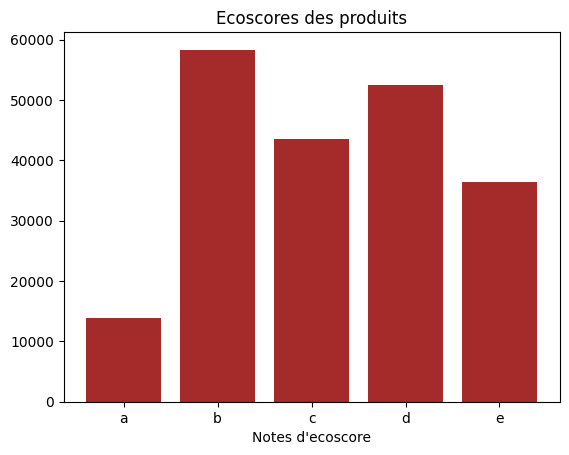

In [55]:
plt.bar(x= ['a','b','c','d','e'], height= env_Wmarques[env_Wmarques.isin(['a','b','c','d','e'])].groupby('ecoscore_grade').ecoscore_grade.count(), color ='brown')
plt.title('Ecoscores des produits')
plt.xlabel("Notes d'ecoscore")

## 5.2 Le respect de l'environnement pour les grandes marques 

In [56]:
col_indicatrice= ['brands_tags','est_plastique','ecoscore_grade','est_palm','est_cocoa']
df_env_indic = df_gdemarq[col_indicatrice]

In [57]:
# on drop les colonnes où l'ecoscore n'est pas applicable et où il est nul 
ind_notapp = df_env_indic.loc[df_env_indic.ecoscore_grade == 'not-applicable'].index
df_env_indic = df_env_indic.drop(index = ind_notapp)
df_env_indic.ecoscore_grade.dropna(inplace=True)

In [58]:
def ord_eco(x):
    if x == 'a':
        return 0
    elif x == 'b':
        return 1
    elif x == 'c':
        return 2
    elif x == 'd':
        return 3
    else:
        return 4
df_env_indic["eco_ord"] = df_env_indic.ecoscore_grade.map(ord_eco)

In [63]:
df_env_indic.groupby('brands_tags')["eco_ord"].mean().mean()

3.0951643508298603

Pour les produits grandes marques, on relève un ecoscore moyen de 3.06 ce qui équivaut à une note moyenne de d. Avec un écart-type de 1.25, les ecoscores sont donc majoritairement concentrés vers d. <br>
Une majorité donc de produit a un écoscore relativement faible.

Text(0, 0.5, 'Ecoscore moyen')

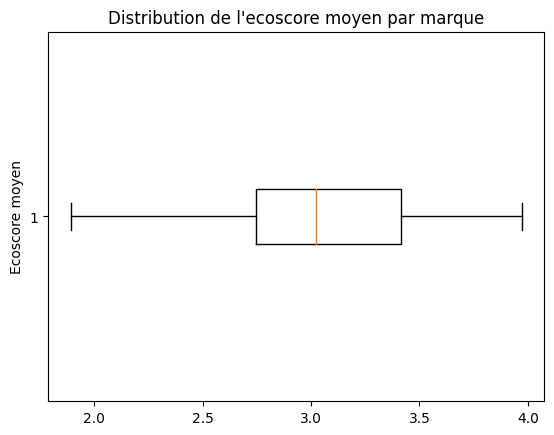

In [64]:
plt.boxplot(df_env_indic.groupby('brands_tags').eco_ord.mean(), vert= False)
plt.title('Distribution de l\'ecoscore moyen par marque')
plt.ylabel('Ecoscore moyen')

### 5.2.1 Les grandes marques ayant le moins bon ecoscore moyen 

In [65]:
worst = pd.DataFrame(df_env_indic.groupby('brands_tags').eco_ord.mean().sort_values(ascending=False)[:10])

Index(['lindt', 'charal', 'haribo', 'myprotein', 'maggi', 'prozis',
       'saint-alby', 'milka', 'palais-des-thes', 'hema'],
      dtype='object', name='brands_tags')

Les marques avec le pire ecoscore moyen  : <br>
- 1.lindtt
- 2.charals
- 3.haribos
- 4.myproteins
- 5.maggis
- 6.prozisi
- 7.saint-albyt
- 8.milkas
- 9.palais des thés
- 10.hema 

### 5.2.2 Les grandes marques ayant le meilleur ecoscore moyen 

In [67]:
best = df_env_indic.groupby('brands_tags').eco_ord.mean().sort_values(ascending=True)[:10]

Index(['carrefour-bio,carrefour', 'u-bio,u', 'bio-village,marque-repere',
       'belle-france', 'grand-jury', 'andros', 'dia', 'franprix', 'bonneterre',
       'la-vie-claire'],
      dtype='object', name='brands_tags')

Les marques avec le meilleur ecoscore moyen  : <br>
- 1. Carrefour bio
- 2. U bio
- 3. Bio village marque repère
- 4. Belle-france
- 5. Grand-jury
- 6. Andros
- 7. Dia
- 8. Franprix
- 9. Bonneterre
- 10. La vie claire

## 5.3 Le respect de l'environnement pour les petites marques 

In [68]:
df_env_indic_pte = df_ptemarq[col_indicatrice]
ind_notapp_pte = df_env_indic_pte.loc[df_env_indic_pte.ecoscore_grade == 'not-applicable'].index
df_env_indic_pte = df_env_indic_pte.drop(index = ind_notapp_pte)
df_env_indic_pte.ecoscore_grade.dropna(inplace=True)
df_env_indic_pte["eco_ord"] = df_env_indic_pte.ecoscore_grade.map(ord_eco)

In [69]:
df_env_indic_pte.eco_ord.mean()

3.1516521069021497

In [70]:
df_env_indic_pte.eco_ord.std()

1.2332633131777242

## 5.4 Bilan 

Text(0.5, 1.0, 'Ecoscore moyen pour les 2 catégories de marques')

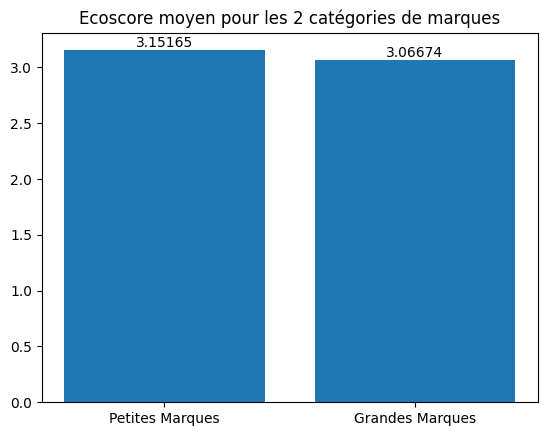

In [71]:
fig, ax = plt.subplots()
bars = ax.bar(['Petites Marques','Grandes Marques'], [df_env_indic_pte.eco_ord.mean(),df_env_indic.eco_ord.mean()])
ax.bar_label(bars)
plt.title('Ecoscore moyen pour les 2 catégories de marques')

Alors que l'ecoscore prend en compte différents critères ( voir : docs.score-environnemental.com ) <br>
Il ne prend pas en compte si un produit contient de l'huile de palme ou s'il a du plastique (...) <br>
La démarche est donc de redéfinir une nouvelle note afin d'obtenir un score plus proche de la réalité. <br>
A savoir qu'un nouvel ecoscore, l'ecobalyse qui comprend de nouveaux critères est actuellement en phase de test pour être déployé en 2024 . <br>
(lien : https://www.ecologie.gouv.fr/affichage-environnemental-des-produits-alimentaires-berangere-couillard-presente-projet-methode ) 

# 6. Quelles sont les marques qui proposent essentiellement des produits biologiques ?

In [16]:
sum_prod_bio = bio_Wmarques[bio_Wmarques['product_name'].notnull()].groupby('brands_tags').size()
bio_Wmarques['count_prod'] = bio_Wmarques['brands_tags'].map(sum_prod_bio)
seuil = 500
df_gdemarq_bio = bio_Wmarques[bio_Wmarques.count_prod >= seuil]
df_ptemarq_bio = bio_Wmarques[bio_Wmarques.count_prod < seuil]

In [28]:
p_gdemarq_prodbio = (df_gdemarq_bio.groupby('brands_tags').est_bio.sum() / df_gdemarq_bio.groupby('brands_tags').count_prod.max()*100).sort_values(ascending=False)

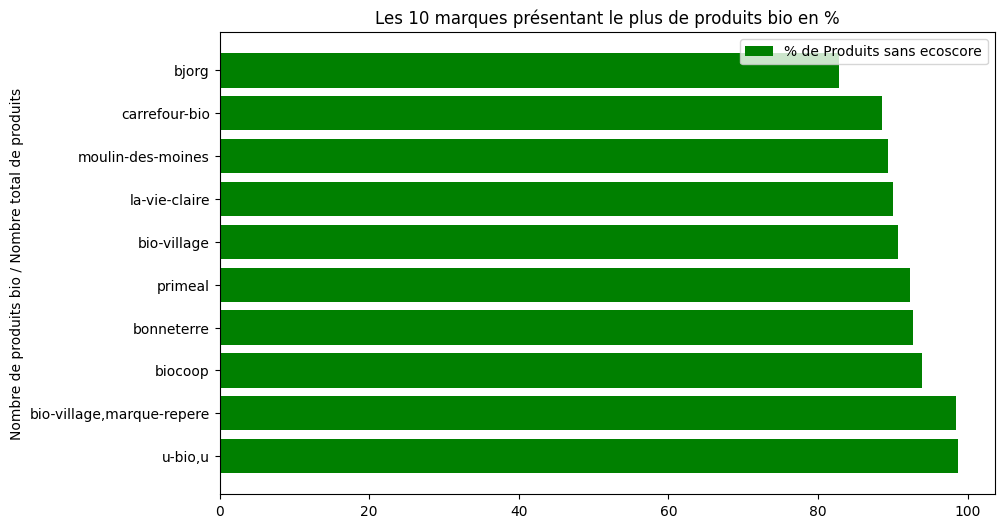

In [29]:
plt.figure(figsize=(10,6))
plt.barh(y = p_gdemarq_prodbio[:10].index  , color='gree', width=p_gdemarq_prodbio[:10])
plt.ylabel('Nombre de produits bio / Nombre total de produits')
plt.title("Les 10 marques présentant le plus de produits bio en %")
plt.legend(labels=['% de Produits sans ecoscore'])
plt.show()

# 8. Observe-t-on une corrélation entre le caratère bio des produits et la qualité nutritionnelle ?



In [30]:
bioqual = pd.merge (bio, qual, on = ['product_name', 'brands_tags'], how = 'outer', indicator = True)

In [31]:
# Création de la table de contingence
X = 'est_bio'
Y = "nutriscore_grade"

cont = bioqual[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

nutriscore_grade,a,b,c,d,e,Total
est_bio,,,,,,
False,27865,26174,42525,59763,40162,196489
True,9843,6692,9134,9626,5491,40786
Total,37708,32866,51659,69389,45653,237275


In [32]:
# Regardons la distribution si les variables étaient complétement independantes

tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(bioqual)
indep = round(tx.dot(ty) / n)

indep

nutriscore_grade,a,b,c,d,e,Total
est_bio,,,,,,
False,8710.0,7591.0,11932.0,16028.0,10545.0,54806.0
True,1808.0,1576.0,2477.0,3327.0,2189.0,11376.0
Total,10518.0,9167.0,14409.0,19355.0,12734.0,66183.0


In [33]:
# regardons où l'écart est le plus important
(cont - indep)/indep*100

nutriscore_grade,a,b,c,d,e,Total
est_bio,,,,,,
False,219.919633,244.803056,256.394569,272.866234,280.862968,258.517316
True,444.413717,324.619289,268.752523,189.329726,150.845135,258.526723
Total,258.509222,258.525145,258.518981,258.506846,258.512643,258.513516


In [36]:
chi2, p, dof, exp = chi2_contingency(cont)

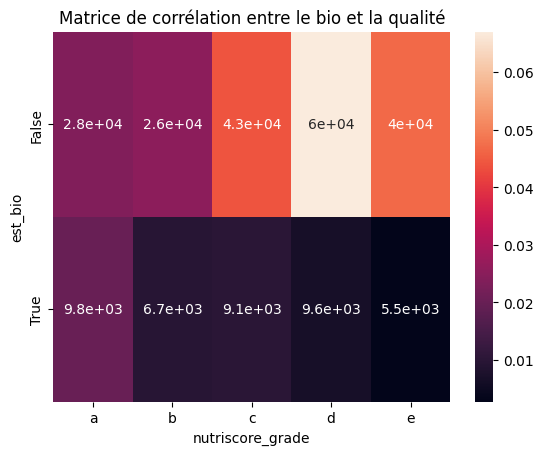

In [37]:
c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.title('Matrice de corrélation entre le bio et la qualité')
plt.show()

# 9. Observe-t-on une corrélation entre la la qualité nutritionnelle et l'aspect envionnemental ?

In [81]:
df_corr_qualenv = envqualbio[['nutriscore_grade','ecoscore_grade']]

In [82]:
# on retire les nutriscore manquants et non applicables
ind_r_ecoscore = df_corr_qualenv.loc[df_corr_qualenv.ecoscore_grade.isin(['d','c', 'b', 'a', 'e'])].index
df_corr_qualenv = df_corr_qualenv.loc[df_corr_qualenv.index.isin(ind_r_ecoscore)]
df_corr_qualenv.dropna(axis=0, inplace=True)

On effectue un test de Chi-2

In [87]:

def chi2(X,Y,df,graph=False,contengency=True):
    cont_1 = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
    if contengency:
        print(cont_1)
    tx = cont_1.loc[:,["Total"]]
    ty = cont_1.loc[["Total"],:]
    n = len(df)
    indep = round(tx.dot(ty) / n)
    chi2, p, dof, expected_freq = chi2_contingency(cont_1)
    ## modifier pour chopper le graph 
    if graph:
        c = cont_1.fillna(0) # On remplace les valeurs nulles par 0
        measure = (c-indep)**2/indep
        xi_n = measure.sum().sum()
        table = measure/xi_n
        sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
        plt.title('Matrice de corrélation')
        plt.show()
    else:
        return chi2, p 

ecoscore_grade       a      b      c      d      e   Total
nutriscore_grade                                          
a                 3922  13635   4387   4722   3587   30253
b                 2067   8135   4701   6903   5229   27035
c                 2194  13196  10917  15458   7052   48817
d                 1452  14630  15154  23940  17346   72522
e                  232   3723   7156  13679  15417   40207
Total             9867  53319  42315  64702  48631  218834


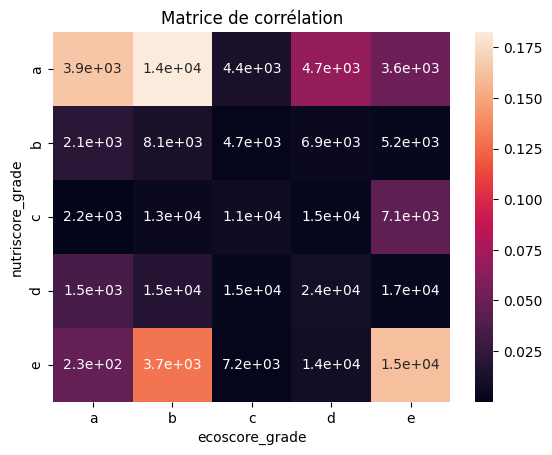

In [88]:
chi2('nutriscore_grade','ecoscore_grade',df_corr_qualenv,graph=True)

Interprétation : 
- Forte corrélation entre l'ecoscore et le nutriscore, plus particulièrement pour les notes "extrêmes"
- Fruit et légumes importés ecoscore important peuvent expliqué la présence notable d'une note d'ecoscore 'e' ou 'd' alors que le nutriscore sera de 'a'
